In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from torchvision.models import convnext_small, ConvNeXt_Small_Weights
import torch.nn as nn
import torch
import pandas as pd
from tl_tools import *

In [2]:
from torch import from_numpy
setup_mixed_precision()
train_dir = '/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/data/USTC_SmokeRS/processed/train'

train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True ,vertical_flip=True)
train =train_datagen.flow_from_directory(train_dir, color_mode= 'rgb', batch_size = 16, shuffle= True, seed = 1, target_size=(256, 256))


X_train, y_train, X_val, y_val = train_val_split(train, val_split= 0.3)

# Convert TF format (NHWC) to PyTorch format (NCHW)
X_train = from_numpy(X_train.numpy()).permute(0, 3, 1, 2)
X_val = from_numpy(X_val.numpy()).permute(0, 3, 1, 2)

#Not necessary for labels
y_train = from_numpy(y_train.numpy())
y_val = from_numpy(y_val.numpy())

Mixed precision policy set to: mixed_float16

Found 4980 images belonging to 6 classes.
Number of batches in the training data: 312
Batch size of a single batch 16
Number of samples in the training dataset 4980

Number of training data batches with val split of 0.3: 219
Number of validation data batches: 93



2024-11-01 15:34:51.627421: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-11-01 15:34:51.627451: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-11-01 15:34:51.627462: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-11-01 15:34:51.627668: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-01 15:34:51.627680: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Shape of image training set: (3504, 256, 256, 3)
Shape of image validation set: (1476, 256, 256, 3)

Shape of label training set: (3504, 6)
Shape of label validation set: (1476, 6)


In [3]:
test_dir = '/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/data/USTC_SmokeRS/processed/test'
test_datagen = ImageDataGenerator(rescale=1./255)
test = test_datagen.flow_from_directory(test_dir, color_mode= 'rgb', batch_size = 16, shuffle= True, seed = 1, target_size=(256, 256))

X_test, y_test = test_splits(test)

X_test = from_numpy(X_test.numpy()).permute(0, 3, 1, 2)
y_test = from_numpy(y_test.numpy())

Found 1245 images belonging to 6 classes.
Number of batches in the test data: 78
Batch size of a single batch 16
Number of samples in the test dataset 1245

Shape of image test set: (1245, 256, 256, 3)

Shape of label test set: (1245, 6)


In [4]:
convnext = convnext_small(weights = ConvNeXt_Small_Weights.IMAGENET1K_V1)
convnext.classifier = nn.Sequential(
    nn.Flatten(),     
    
    #FC 1                       
    nn.Linear(in_features=768, out_features=64),   
    nn.ReLU(),
    nn.BatchNorm1d(64), 
    nn.Dropout1d(p=0.3), 
           
    #FC 2                                           
    nn.Linear(in_features=64, out_features=32),
    nn.ReLU(), 
    nn.BatchNorm1d(32),  
    nn.Dropout1d(p=0.3), 
    
    #Softmax
    nn.Linear(in_features=32, out_features=6),  
    nn.Softmax(dim=1)                                           
)

#Freezing the convlayers
for param in convnext.features.parameters(): 
    param.requires_grad = False

convnext

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [5]:
optimizer = torch.optim.Adam(convnext.parameters(), lr = 0.001)
for group in optimizer.param_groups: 
    group['max_norm'] = 1.0

criterion = nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode = 'min', 
    factor = 0.5, 
    patience = 8, 
    min_lr = 1e-6
)

In [6]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 16, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle = False)

In [7]:
# Move model to GPU if available, otherwise CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
convnext = convnext.to(device)

# Training loop with early stopping and reduce LR
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50):
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 15  # Early stopping patience
    start_epoch_patience = 20  # Start early stopping after epoch 20
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets.argmax(1)).sum().item()
        
        train_loss = train_loss/len(train_loader)
        train_acc = 100.*correct/total
        
        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets.argmax(1)).sum().item()
        
        val_loss = val_loss/len(val_loader)
        val_acc = 100.*correct/total
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Store history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        # Print progress
        print(f'Epoch: {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 50)
        
        # Early stopping check (after epoch 20)
        if epoch >= start_epoch_patience:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
                
            if patience_counter >= patience:
                print(f'Early stopping triggered at epoch {epoch+1}')
                model.load_state_dict(best_model_state)  # Restore best model
                break
    
    return model, history


#model, history = train_model(convnext, train_loader, val_loader, criterion, optimizer, scheduler)

In [8]:
#Saving the model for later use
#torch.save({'model_state_dict': convnext.state_dict(),'optimizer_state_dict': optimizer.state_dict(),
            #'history': history,}, 'convnext_model.pth')

In [9]:
checkpoint = torch.load('convnext_model.pth', weights_only= False)
convnext.load_state_dict(checkpoint['model_state_dict'])

convnext.eval()
predictions = list()
true_labels = list()

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = convnext(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(torch.argmax(targets, dim=1).numpy())

predictions = np.array(predictions)
true_labels = np.array(true_labels)

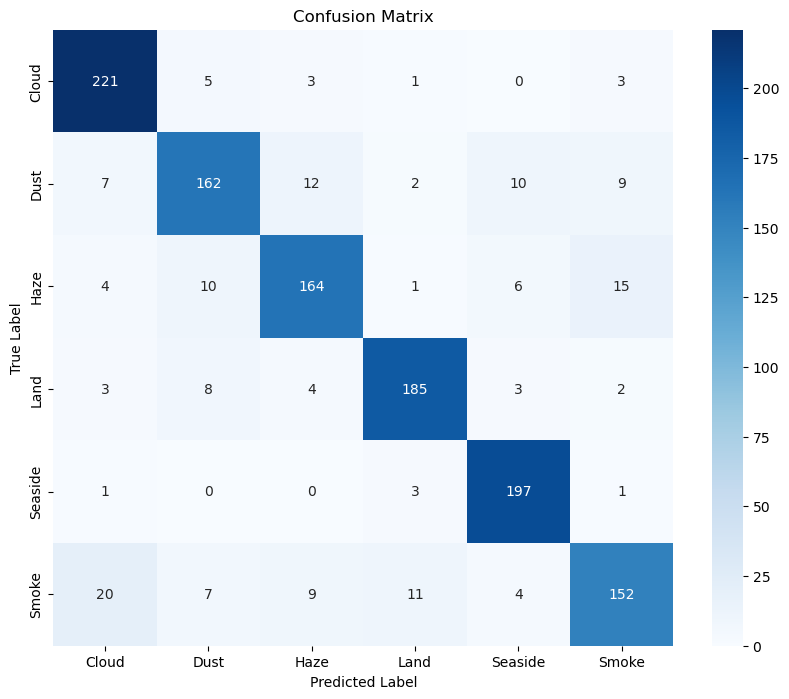

In [10]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class_labels = list(test.class_indices.keys())
confusion_mat = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [11]:
n_classes = len(class_labels)
FP = confusion_mat.sum(axis=0) - np.diag(confusion_mat)
FN = confusion_mat.sum(axis=1) - np.diag(confusion_mat)
TP = np.diag(confusion_mat)
TN = confusion_mat.sum() - (FP + FN + TP)

metrics = ['Precision', 'Recall', 'F1-score', 'False Negative Rate']

df_metrics = pd.DataFrame(index=metrics, columns=class_labels)

for i in range(n_classes):
    df_metrics.iloc[0, i] = TP[i] / (TP[i] + FP[i])
    df_metrics.iloc[1, i] = TP[i] / (TP[i] + FN[i])
    df_metrics.iloc[2, i] = 2 * TP[i] / (2 * TP[i] + FP[i] + FN[i])
    df_metrics.iloc[3, i] = FN[i] / (FN[i] + TP[i])  # False Negative Rate

def round_fn(input): 
    return round(input, 4)

df_metrics = df_metrics.map(round_fn)
df_metrics

,Cloud,Dust,Haze,Land,Seaside,Smoke
Precision,0.8633,0.8438,0.8542,0.9113,0.8955,0.8352
Recall,0.9485,0.8020,0.8200,0.9024,0.9752,0.7488
F1-score,0.9039,0.8223,0.8367,0.9069,0.9336,0.7896
False Negative Rate,0.0515,0.1980,0.1800,0.0976,0.0248,0.2512


In [12]:
from sklearn.metrics import accuracy_score

print(f'Accuracy Score: {accuracy_score(true_labels, predictions):.4f}')
for index, row in df_metrics.iterrows(): 
    row_mean = row.mean()
    print(f'Average {index} Score: {row_mean:.4f}')

Accuracy Score: 0.8683
Average Precision Score: 0.8672
Average Recall Score: 0.8662
Average F1-score Score: 0.8655
Average False Negative Rate Score: 0.1338


In [13]:
# Create feature extractor model
class FeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super().__init__()
        self.features = original_model.features
        self.avgpool = original_model.avgpool

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        return x.view(x.size(0), -1)  # Flatten the output

# Create feature extractor
feature_extractor = FeatureExtractor(convnext)
feature_extractor = feature_extractor.to(device)
feature_extractor.eval()  # Set to evaluation mode

# Extract features
features = []
with torch.no_grad():
    for inputs, _ in test_loader:  # We don't need the labels here
        inputs = inputs.to(device)
        batch_features = feature_extractor(inputs)
        features.extend(batch_features.cpu().numpy())

feature_extractor_pred = np.array(features)

In [89]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
feature_extractor_pred = scaler.fit_transform(feature_extractor_pred)
feature_extractor_df = pd.DataFrame(feature_extractor_pred)
y_true_series = pd.Series(true_labels)

class_mapping = dict()
for i, label in enumerate(class_labels): 
    class_mapping[i] = label

y_true_labels = y_true_series.map(class_mapping)

In [87]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2, random_state= 1, perplexity= 30, max_iter = 2000, learning_rate= 'auto', init = 'pca')
X_tsne = tsne.fit_transform(feature_extractor_df)
tsne_df = pd.DataFrame(data = {
    'x1': X_tsne[:, 0], 
    'x2': X_tsne[:, 1], 
    'class': y_true_series
})

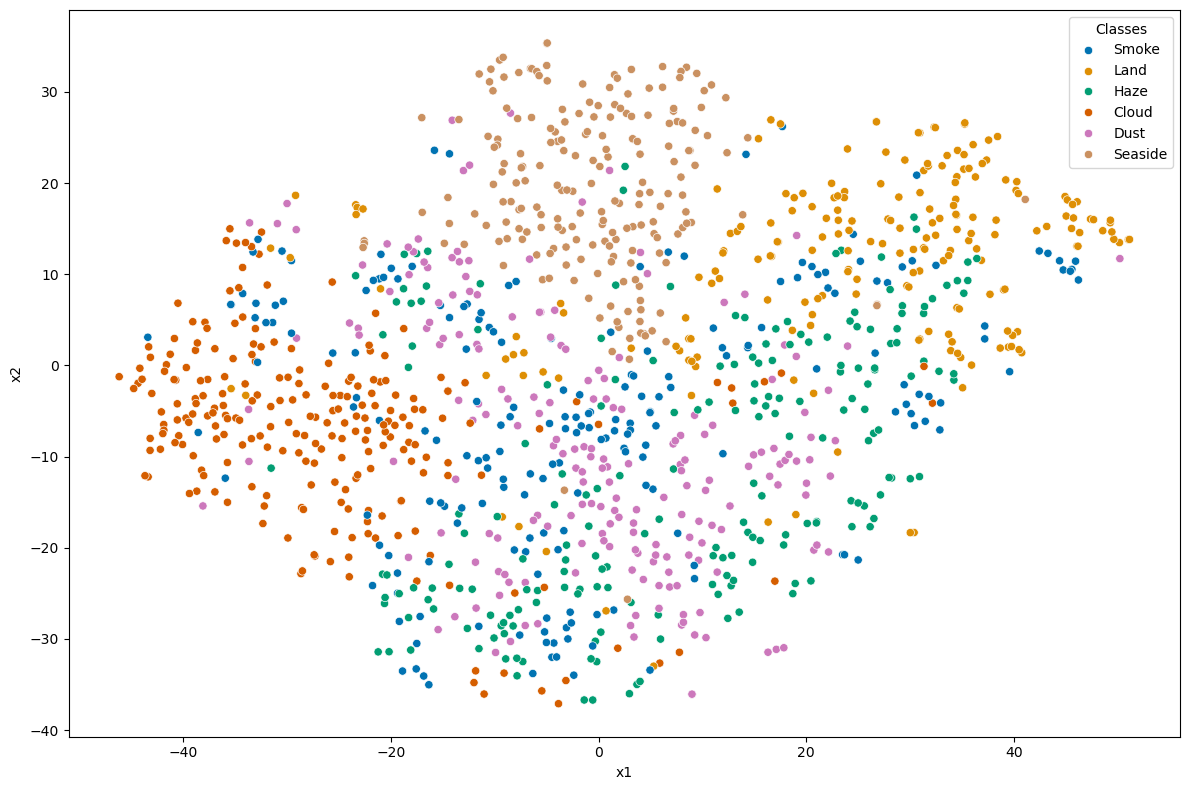

In [91]:
plt.figure(figsize= (12, 8))
scatter = sns.scatterplot(x = 'x1', y = 'x2', data = tsne_df, hue = y_true_labels, palette = 'colorblind')
scatter.legend(title = 'Classes')
plt.tight_layout()
plt.show()

In [98]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Your existing code
features = tsne_df[['x1','x2']]
kmeans = KMeans(n_clusters=6, max_iter=1500, random_state=1)
kmeans.fit(features)

# Get cluster labels
cluster_labels = kmeans.labels_

# Calculate evaluation metrics
silhouette = silhouette_score(features, cluster_labels)
calinski = calinski_harabasz_score(features, cluster_labels)
davies = davies_bouldin_score(features, cluster_labels)

# Print results
print(f"Silhouette Score: {silhouette:.3f}")
print(f"Calinski-Harabasz Score: {calinski:.3f}")
print(f"Davies-Bouldin Score: {davies:.3f}")

# Compare with true labels
true_labels = pd.factorize(tsne_df['class'])[0]
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)

print(f"Adjusted Rand Index: {ari:.3f}")
print(f"Normalized Mutual Information: {nmi:.3f}")

Silhouette Score: 0.386
Calinski-Harabasz Score: 1306.373
Davies-Bouldin Score: 0.868
Adjusted Rand Index: 0.309
Normalized Mutual Information: 0.352
